## SVM

A support vector machine (SVM) is a powerful and versatile machine learning model, capable of performing linear or nonlinear classification, regression, and even novelty detection. SVMs shine with small to medium-sized nonlinear datasets (i.e., hundreds to thousands of instances), especially for classification tasks. However, they don’t scale very well to very large datasets, as you will see.

## Linear SVM Classification

The fundamental idea behind SVMs is best explained with some visuals. Figure 5-1 shows part of the iris dataset that was introduced at the end of Chapter 4. The two classes can clearly be separated easily with a straight line (they are linearly separable). The left plot shows the decision boundaries of three possible linear classifiers. The model whose decision boundary is represented by the dashed line is so bad that it does not even separate the classes properly. The other two models work perfectly on this training set, but their decision boundaries come so close to the instances that these models will probably not perform as well on new instances. In contrast, the solid line in the plot on the right represents the decision boundary of an SVM classifier; this line not only separates the two classes but also stays as far away from the closest training instances as possible. You can think of an SVM classifier as fitting the widest possible street (represented by the parallel dashed lines) between the classes. This is called large margin classification.

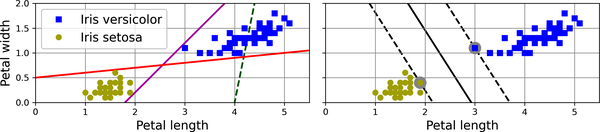

Fig :- Large Margine CLassification

Notice that adding more training instances “off the street” will not affect the decision boundary at all: it is fully determined (or “supported”) by the instances located on the edge of the street. These instances are called the support vector

Warning
SVMs are sensitive to the feature scales, as you can see in Figure 5-2. In the left plot, the vertical scale is much larger than the horizontal scale, so the widest possible street is close to horizontal. After feature scaling (e.g., using Scikit-Learn’s StandardScaler), the decision boundary in the right plot looks much better.

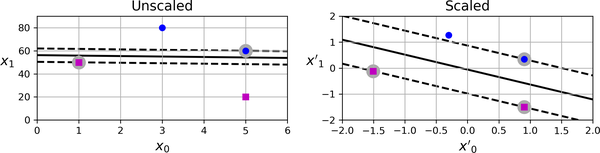


## Soft Margin Classification

If we strictly impose that all instances must be off the street and on the correct side, this is called hard margin classification. There are two main issues with hard margin classification. First, it only works if the data is linearly separable. Second, it is sensitive to outliers. Figure 5-3 shows the iris dataset with just one additional outlier: on the left, it is impossible to find a hard margin; on the right, the decision boundary ends up very different from the one we saw in Figure 5-1 without the outlier, and the model will probably not generalize as well.

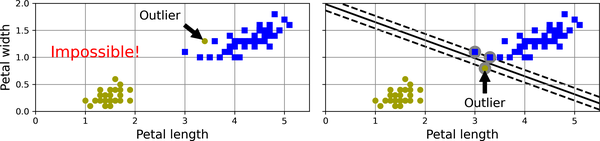

Figure. Hard margin sensitivity to outliers

To avoid these issues, we need to use a more flexible model. The objective is to find a good balance between keeping the street as large as possible and limiting the margin violations (i.e., instances that end up in the middle of the street or even on the wrong side). This is called soft margin classification.

When creating an SVM model using Scikit-Learn, you can specify several hyperparameters, including the regularization hyperparameter C. If you set it to a low value, then you end up with the model on the left of Figure 5-4. With a high value, you get the model on the right. As you can see, reducing C makes the street larger, but it also leads to more margin violations. In other words, reducing C results in more instances supporting the street, so there’s less risk of overfitting. But if you reduce it too much, then the model ends up underfitting, as seems to be the case here: the model with C=100 looks like it will generalize better than the one with C=1.

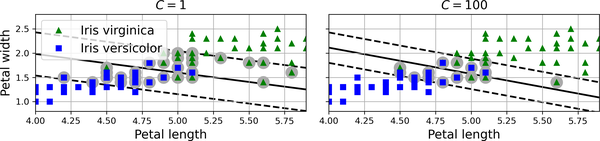

Figure. Large margin (left) versus fewer margin violations (right)



In [5]:
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# load iris dataset
iris = load_iris(as_frame=True)
X = iris.data[['petal length (cm)', 'petal width (cm)']]
y = (iris.target == 2) # iris virginica

svm_clf = make_pipeline(StandardScaler(), LinearSVC(C=1, random_state=42))

svm_clf.fit(X.values, y.values)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, random_state=42))])

In [6]:
X_new = [[5.5, 1.7], [5.0, 1.5]]
svm_clf.predict(X_new) # first is classified as virginica and secons as not

array([ True, False])

In [7]:
svm_clf.decision_function(X_new) # signed distance from the decision boundary

array([ 0.66163816, -0.22035761])

- Unlike LogisticRegression, LinearSVC doesn’t have a predict_proba() method to estimate the class probabilities. That said, if you use the SVC class (discussed shortly) instead of LinearSVC, and if you set its probability hyperparameter to True, then the model will fit an extra model at the end of training to map the SVM decision function scores to estimated probabilities. Under the hood, this requires using 5-fold cross-validation to generate out-of-sample predictions for every instance in the training set, then training a LogisticRegression model, so it will slow down training considerably. After that, the predict_proba() and predict_log_proba() methods will be available.

## Nonlinear SVM Classification

Although linear SVM classifiers are efficient and often work surprisingly well, many datasets are not even close to being linearly separable. One approach to handling nonlinear datasets is to add more features, such as polynomial features (as we did in Chapter 4); in some cases this can result in a linearly separable dataset. Consider the lefthand plot in Figure 5-5: it represents a simple dataset with just one feature, x1. This dataset is not linearly separable, as you can see. But if you add a second feature x2 = (x1)2, the resulting 2D dataset is perfectly linearly separable.

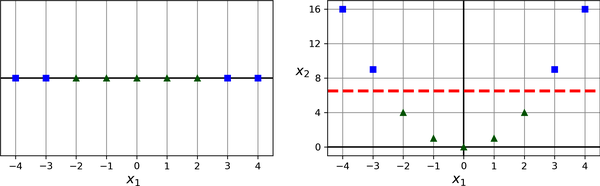

Figure. Adding features to make a dataset linearly separable


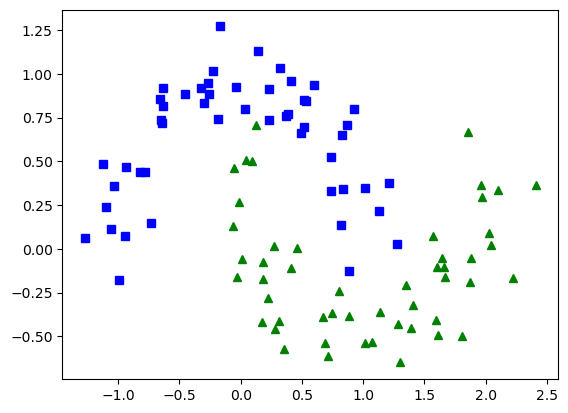

In [10]:
## lets test with moons dataset
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

In [11]:
lin_svm = make_pipeline(PolynomialFeatures(degree=3), StandardScaler(), LinearSVC(C=10, random_state=42))
lin_svm.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=10, random_state=42))])

## Polynomial Kernel

Adding polynomial features is simple to implement and can work great with all sorts of machine learning algorithms (not just SVMs). That said, at a low polynomial degree this method cannot deal with very complex datasets, and with a high polynomial degree it creates a huge number of features, making the model too slow.

Fortunately, when using SVMs you can apply an almost miraculous mathematical technique called the kernel trick (which is explained later in this chapter). The kernel trick makes it possible to get the same result as if you had added many polynomial features, even with a very high degree, without actually having to add them. This means there’s no combinatorial explosion of the number of features. This trick is implemented by the SVC class. Let’s test it on the moons dataset:

In [12]:
from sklearn.svm import SVC
poly_kernel_svm_clf = make_pipeline(StandardScaler(), SVC(kernel='poly', degree=3, coef0=1, C=5))
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

This code trains an SVM classifier using a third-degree polynomial kernel, represented on the left in Figure 5-7. On the right is another SVM classifier using a 10th-degree polynomial kernel. Obviously, if your model is overfitting, you might want to reduce the polynomial degree. Conversely, if it is underfitting, you can try increasing it. The hyperparameter coef0 controls how much the model is influenced by high-degree terms versus low-degree terms.

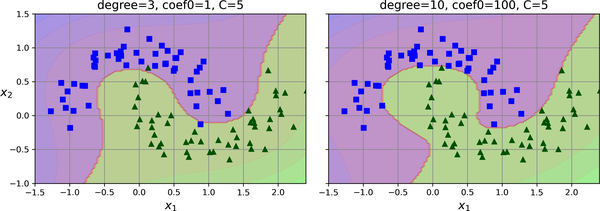

Figure. SVM classifiers with a polynomial kernel

Tip
Although hyperparameters will generally be tuned automatically (e.g., using randomized search), it’s good to have a sense of what each hyperparameter actually does and how it may interact with other hyperparameters: this way, you can narrow the search to a much smaller space
